## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df_treatment = df.query('group == "treatment" and landing_page == "old_page"')
df_control = df.query('group == "control" and landing_page == "new_page"')

len(df_treatment + df_control)

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [8]:
df1 = df.drop(df_treatment.index) # drop the mismatched data
df2 = df1.drop(df_control.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [13]:
df2.drop_duplicates(subset = "user_id", inplace = True)

In [14]:
print(df2.user_id.nunique()) #print unique values
print(df2.shape[0]) # print number of rows

290584
290584


**3. Probability**

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

 - **Since the Probability of converting whether the user is in Treatment or Control group is around 12%, there isn't enough evidence that the new treatment page leads to more conversions.**
 - **Also the probability of landing on new_page is 50% which further conculdes that the evidence is insufficient.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation is observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  


`1.` Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the  null and alternative hypotheses can be stated as:

 - **H0: $p_{old}$ $>=$ $p_{new}$**
 - **H1: $p_{old}$ $<$ $p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = len(df2.query('group == "control"'))
n_old

145274

In [23]:
p_new - p_old

0.0

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = ([1 - p_new, p_new]))
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = ([1 - p_old, p_old]))
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.0027992363803175518

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs = []
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted 
p_diffs

array([ 0.00039725,  0.00106489,  0.00286809, ..., -0.00029097,
        0.00030757, -0.00078653])

i. Plot a histogram of the **p_diffs**.

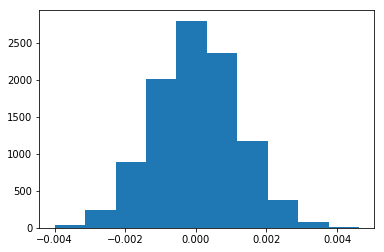

In [28]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
act_diff = (df2.query('group == "treatment"')['converted'].mean()) - (df2.query('group == "control"')['converted'].mean())
(p_diffs > act_diff).mean()

0.90869999999999995

**The above calculated difference in proportion of converts in simulated and actual difference is called p-value. Since the p-value is 0.90, it can be said that the Null hypothesis cannot be rejected i.e The new page does not increase the rate of conversion**

l. We could also use a built-in to achieve similar results. Let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = (df2.query('group == "control"')['converted'].sum())
convert_new = (df2.query('group == "treatment"')['converted'].sum())
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
print("old_page_conversions:", convert_old)
print("new_page_conversions:", convert_new)
print("total_old_pages:", n_old)
print("total_new_pages:", n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


old_page_conversions: 17489
new_page_conversions: 17264
total_old_pages: 145274
total_new_pages: 145310


m. Now, using `stats.proportions_ztest` to compute test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
stat, pval = sm.stats.proportions_ztest(count = [convert_old, convert_new], nobs = [n_old, n_new], alternative = "smaller")
print("z-score:", stat)
print("p-value:", pval)

z-score: 1.31092419842
p-value: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score and p-value from the above calculation clearly state that the Null Hypothesis cannot be rejected. This matches with the findings of the p-value calculated using simulation.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we can observe that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a. Since each row is either a conversion or no conversion, Logistic Regression can be performed in this case since there are only two values of converted or not_converted and can be only 1 or 0.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

- Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2[['control', 'treatment']] = pd.get_dummies(df['group'])
df2['ab_page'] = df2['treatment']
df2['intercept'] = 1

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [34]:
logit_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = logit_m.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-22 09:25 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**The above summary shows the coefficient value of ab_page as negative, which means that it does not affect conversion. The same can be observed from the high p-value as well**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**The p-value associated with ab_page is 0.19 which is different from the p-value(0.90) found in part 2. The reason for the difference in p-value is because of the type of hypothesis tests in the two parts.**

- In A/B testing, it is one-tailed test.
- In regression model, it is a two-tailed test

**For the regression, the Null and Alternative hypothesis**
- **H0: $p_{old}$ $=$ $p_{new}$**
- **H1: $p_{old}$ $!=$ $p_{new}$**

**Both the tests show same conclusion that the Null hypothesis holds true and cannot be rejected.**

f. Now, considering other things that might influence whether or not an individual converts, it can be a good idea to consider other factors to add into the regression model.

**There might be other factors that can influence the conversion and they should also be checked before completely rejecting a hypothesis. Also, adding an irrelevant variable can increase the variance of the estimate of other correlation coefficient and will not have any benefits.**

g. Now along with testing if the conversion rate changes for different pages, add an effect based on which country a user lives in. Need to read in the **countries.csv** dataset and merge together both datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [35]:
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
df2 = df2.join(df_c.set_index('user_id'), on = 'user_id')

In [37]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1,US,0,0,1


In [39]:
logit_m = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
res = logit_m.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-22 09:25 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**From the above output, it does not appear that the country variable had any influence on the conversion as the p-values for all the countries are very high**

h. We can now look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.

In [40]:
logit_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
res = logit_m.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-22 09:25 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

<a id='conclusions'></a>

## Conclusions

- **The output from all the variables combined shows that none of the variables influence the conversion as all of them have p-values higher than 0.05. Thus it can be conclusively said that the Null Hypothesis cannot be rejected.**

- **Thus there is no significant evidence of more conversion in the New Page than the old page. Thus the New page cannot be launched**

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0